In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
df = pd.read_csv('cardio_train.csv')


In [ ]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df.tail()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [ ]:
df.shape

(70000, 13)

In [ ]:
df.describe()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df['cardio'].value_counts()

,count
cardio,
0,35021
1,34979


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

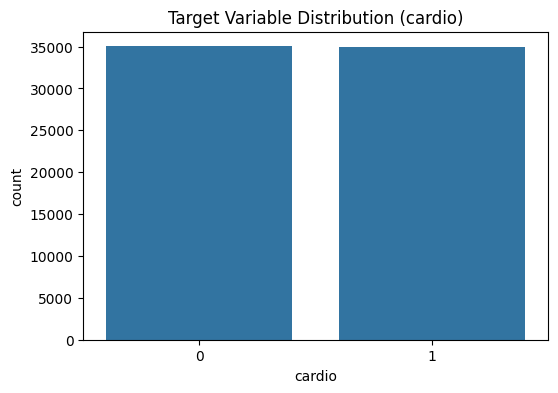

In [ ]:
# Distribution of target variable
plt.figure(figsize=(6,4))
sns.countplot(x='cardio', data=df)
plt.title('Target Variable Distribution (cardio)')
plt.show()

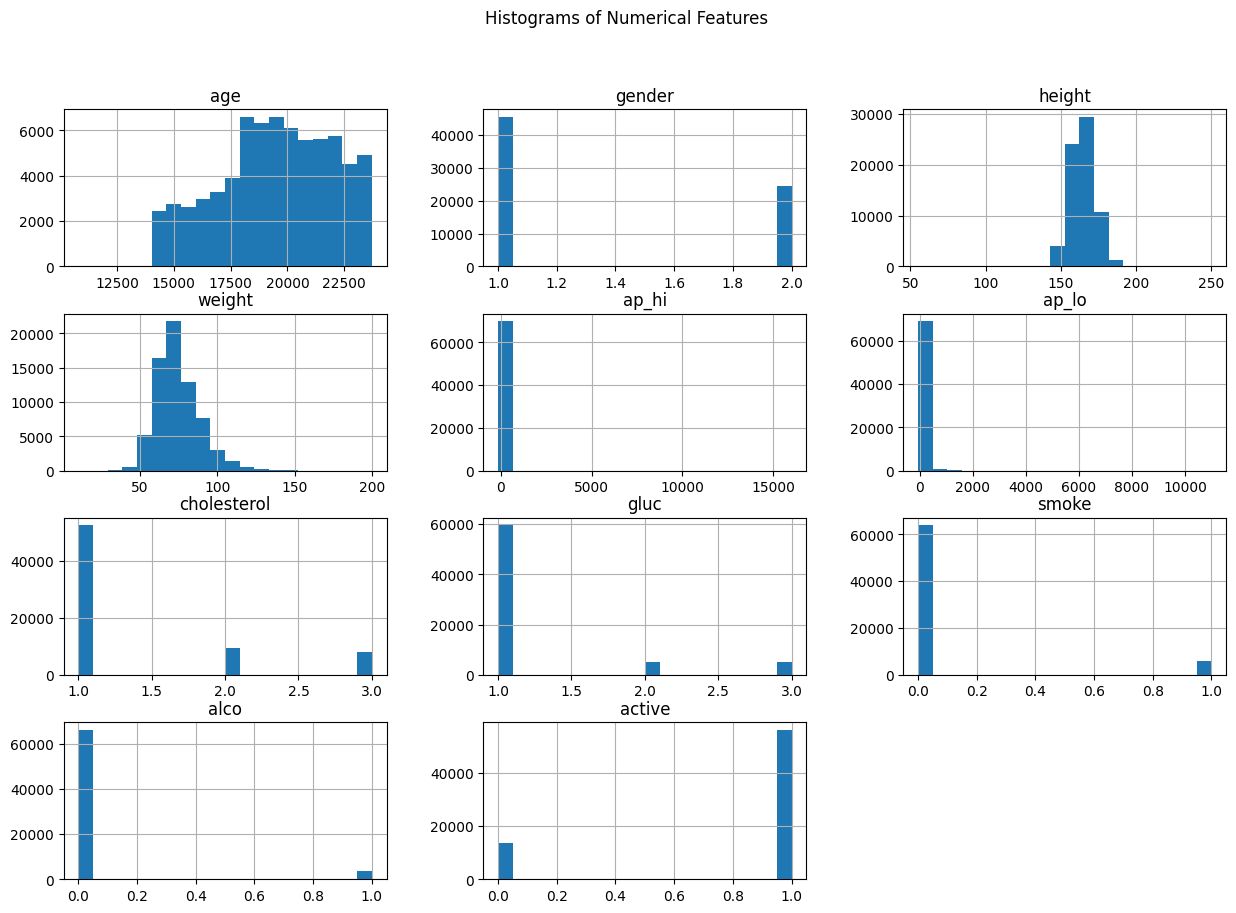

In [ ]:
# Histograms for numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('cardio')
df[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

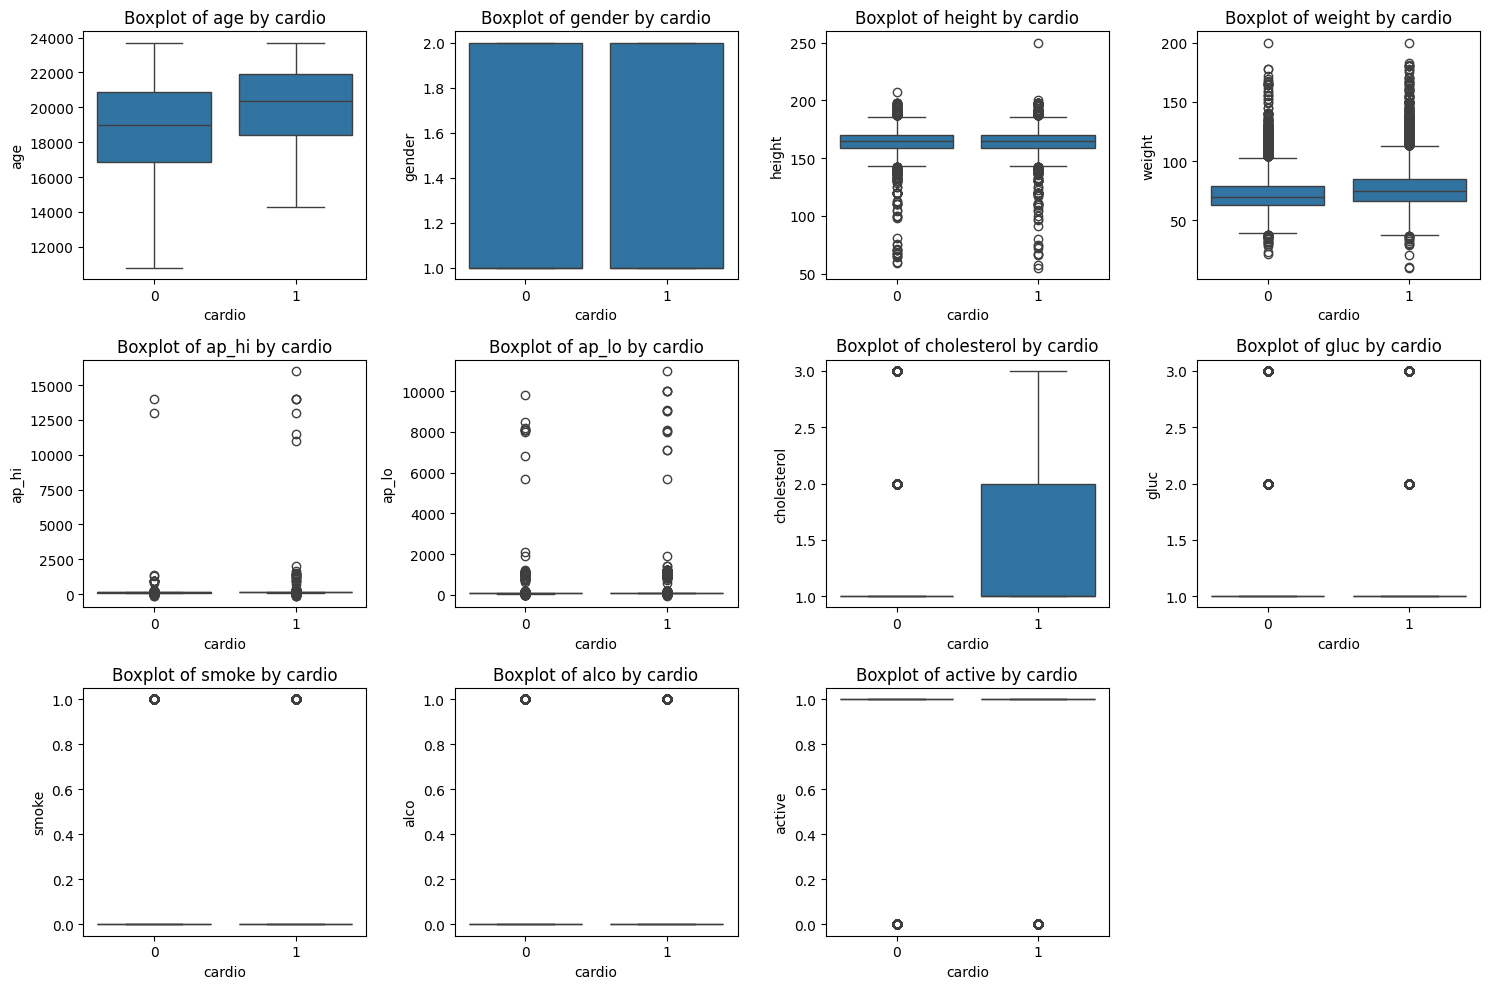

In [ ]:
# Boxplots to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='cardio', y=col, data=df)
    plt.title(f'Boxplot of {col} by cardio')
plt.tight_layout()
plt.show()

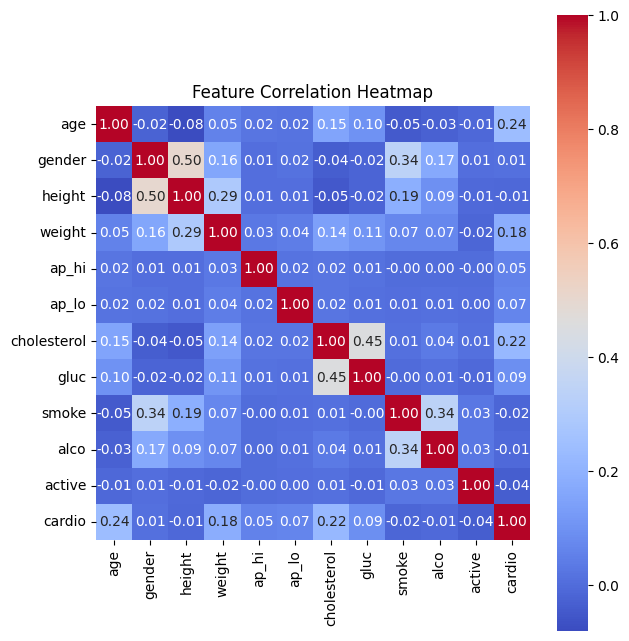

In [ ]:
# Correlation heatmap
plt.figure(figsize=(7, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

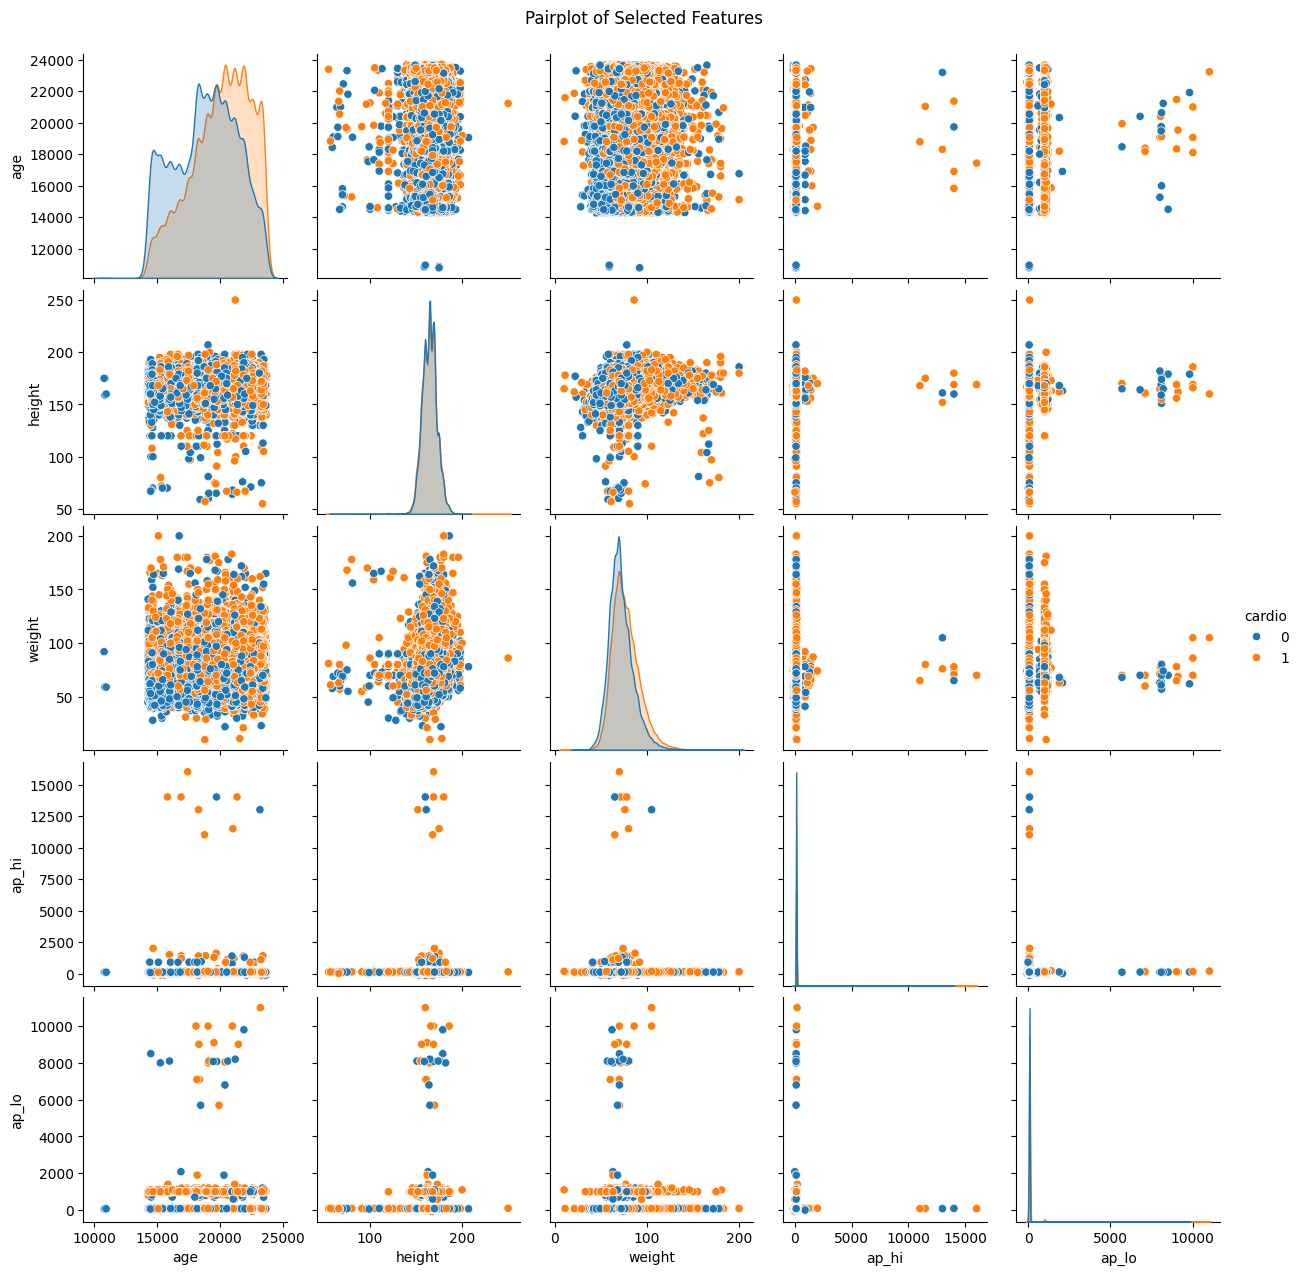

In [ ]:
# Pairplot for a subset of features (optional, can be slow for many features)
subset_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cardio']
sns.pairplot(df[subset_cols], hue='cardio', diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

In [ ]:
# Dropping 'id' column
if 'id' in df.columns:
    df.drop(columns='id', inplace=True)

In [ ]:
df = df.dropna()

In [ ]:
# Separating features and target
X = df.drop('cardio', axis=1)
y = df['cardio']


In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [ ]:
#defining tabnet components
class GLU_Block(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features * 2)

    def forward(self, x):
        x_proj = self.fc(x)
        x_a, x_b = x_proj.chunk(2, dim=-1)
        return x_a * torch.sigmoid(x_b)

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, shared=None):
        super().__init__()
        self.shared = shared
        self.fc = GLU_Block(input_dim, output_dim)

    def forward(self, x):
        if self.shared is not None:
            x = self.shared(x)
        return self.fc(x)

class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x, prior):
        x = self.fc(x)
        return F.softmax(x * prior, dim=-1)

class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_d=8, n_steps=5, gamma=1.3):
        super().__init__()
        self.input_dim = input_dim
        self.n_d = n_d
        self.n_steps = n_steps
        self.gamma = gamma

        self.initial_transform = FeatureTransformer(input_dim, n_d)
        self.shared = GLU_Block(n_d, n_d)
        self.steps = nn.ModuleList()

        for _ in range(n_steps):
            self.steps.append(nn.ModuleDict({
                'feature': FeatureTransformer(n_d, n_d, shared=self.shared),
                'attentive': AttentiveTransformer(n_d)
            }))

        self.fc = nn.Linear(n_d, output_dim)

    def forward(self, x):
        out = 0
        batch_size, input_dim = x.shape
        prior = torch.ones((batch_size, self.n_d)).to(x.device)
        x = self.initial_transform(x)

        for step in self.steps:
            m = step['attentive'](x, prior)
            x_masked = m * x
            x_trans = step['feature'](x_masked)
            out += x_trans
            prior = prior * (self.gamma - m)

        return self.fc(out)

In [ ]:
# Train the Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabNet(input_dim=X_train.shape[1], output_dim=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.5987
Epoch 2, Loss: 0.5496
Epoch 3, Loss: 0.5455
Epoch 4, Loss: 0.5470
Epoch 5, Loss: 0.5440
Epoch 6, Loss: 0.5441
Epoch 7, Loss: 0.5432
Epoch 8, Loss: 0.5430
Epoch 9, Loss: 0.5421
Epoch 10, Loss: 0.5429
Epoch 11, Loss: 0.5421
Epoch 12, Loss: 0.5437
Epoch 13, Loss: 0.5418
Epoch 14, Loss: 0.5410
Epoch 15, Loss: 0.5409
Epoch 16, Loss: 0.5409
Epoch 17, Loss: 0.5410
Epoch 18, Loss: 0.5404
Epoch 19, Loss: 0.5404
Epoch 20, Loss: 0.5399
Epoch 21, Loss: 0.5402
Epoch 22, Loss: 0.5402
Epoch 23, Loss: 0.5401
Epoch 24, Loss: 0.5406
Epoch 25, Loss: 0.5398
Epoch 26, Loss: 0.5393
Epoch 27, Loss: 0.5392
Epoch 28, Loss: 0.5392
Epoch 29, Loss: 0.5392
Epoch 30, Loss: 0.5391
Epoch 31, Loss: 0.5391
Epoch 32, Loss: 0.5387
Epoch 33, Loss: 0.5384
Epoch 34, Loss: 0.5383
Epoch 35, Loss: 0.5385
Epoch 36, Loss: 0.5383
Epoch 37, Loss: 0.5381
Epoch 38, Loss: 0.5388
Epoch 39, Loss: 0.5383
Epoch 40, Loss: 0.5383
Epoch 41, Loss: 0.5383
Epoch 42, Loss: 0.5384
Epoch 43, Loss: 0.5379
Epoch 44, Loss: 0.53

In [ ]:
model.eval()
y_pred_list = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_pred_list.extend(torch.argmax(preds, dim=1).cpu().numpy())

print("Accuracy:", accuracy_score(y_test, y_pred_list))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_list))
print("Classification Report:\n", classification_report(y_test, y_pred_list))


Accuracy: 0.7382857142857143
Confusion Matrix:
 [[5318 1670]
 [1994 5018]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.74      6988
           1       0.75      0.72      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [ ]:


model.eval()
y_pred_list = []
y_proba_list = []  # Store predicted probabilities for positive class

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb)  # Shape: [batch_size, num_classes]
        probs = torch.softmax(preds, dim=1)  # Convert logits to probabilities
        y_proba_list.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
        y_pred_list.extend(torch.argmax(preds, dim=1).cpu().numpy())

# Convert lists to numpy arrays
y_proba_array = np.array(y_proba_list)
y_pred_array = np.array(y_pred_list)

print("Accuracy:", accuracy_score(y_test, y_pred_array))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_array))
print("Classification Report:\n", classification_report(y_test, y_pred_array))

# Calculate and print AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba_array)
print(f"AUC-ROC Score: {auc_roc:.4f}")


Accuracy: 0.7382857142857143
Confusion Matrix:
 [[5318 1670]
 [1994 5018]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.74      6988
           1       0.75      0.72      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

AUC-ROC Score: 0.8005


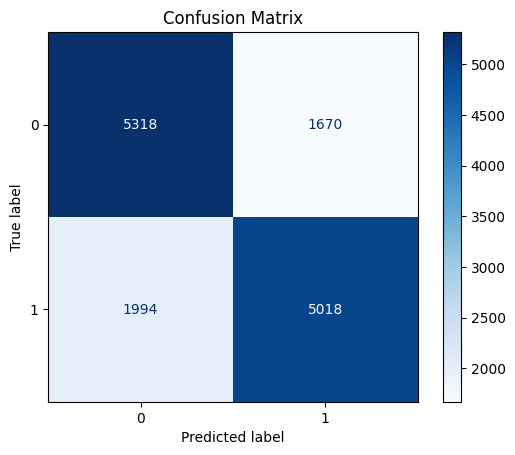

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Suppose y_test are your true labels and y_pred_list are predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_list)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


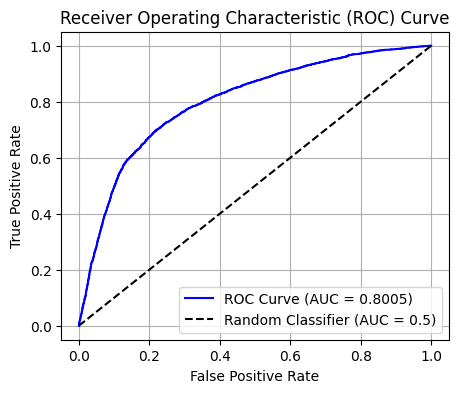

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_test are true labels and y_proba_array are predicted probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_proba_array)
auc_score = roc_auc_score(y_test, y_proba_array)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Save model state_dict
torch.save(model.state_dict(), 'tabnet_model_state_dict.pkl')


In [ ]:
input_dim = X_train.shape[1]  # number of features, e.g., 10
output_dim = 2                # number of classes, e.g., 2 for binary classification

model = TabNet(input_dim=input_dim, output_dim=output_dim)
model.load_state_dict(torch.load('tabnet_model_state_dict.pkl'))
model.eval()


TabNet(
  (initial_transform): FeatureTransformer(
    (fc): GLU_Block(
      (fc): Linear(in_features=11, out_features=16, bias=True)
    )
  )
  (shared): GLU_Block(
    (fc): Linear(in_features=8, out_features=16, bias=True)
  )
  (steps): ModuleList(
    (0-4): 5 x ModuleDict(
      (feature): FeatureTransformer(
        (shared): GLU_Block(
          (fc): Linear(in_features=8, out_features=16, bias=True)
        )
        (fc): GLU_Block(
          (fc): Linear(in_features=8, out_features=16, bias=True)
        )
      )
      (attentive): AttentiveTransformer(
        (fc): Linear(in_features=8, out_features=8, bias=True)
      )
    )
  )
  (fc): Linear(in_features=8, out_features=2, bias=True)
)

In [ ]:
# Replace these with your actual feature and output dimensions
input_dim = X_train.shape[1]  # e.g., 10
output_dim = 2                # e.g., 2 classes for binary classification

model = TabNet(input_dim=input_dim, output_dim=output_dim)



In [ ]:
model.load_state_dict(torch.load('tabnet_model_state_dict.pkl'))


<All keys matched successfully>

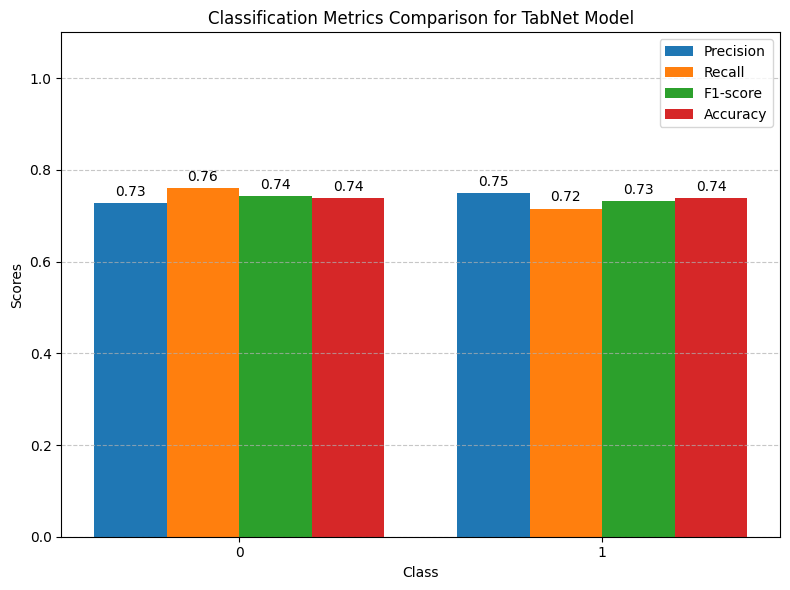

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Replace these with your actual true and predicted labels
# y_test = ...
# y_pred_array = ...

# Compute classification report and accuracy
report = classification_report(y_test, y_pred_array, output_dict=True)
accuracy = accuracy_score(y_test, y_pred_array)

# Extract metrics for classes '0' and '1'
classes = ['0', '1']
metrics = ['precision', 'recall', 'f1-score']

# Prepare data for plotting
data = []
for metric in metrics:
    data.append([report[cls][metric] for cls in classes])

# Add accuracy as a separate list (same accuracy for both classes for visualization)
accuracy_list = [accuracy] * len(classes)

# Convert to numpy arrays for easier manipulation
data = np.array(data)
accuracy_arr = np.array(accuracy_list)

# Plotting parameters
x = np.arange(len(classes))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(8,6))

# Plot bars for each metric
rects1 = ax.bar(x - 1.5*width, data[0], width, label='Precision')
rects2 = ax.bar(x - 0.5*width, data[1], width, label='Recall')
rects3 = ax.bar(x + 0.5*width, data[2], width, label='F1-score')
rects4 = ax.bar(x + 1.5*width, accuracy_arr, width, label='Accuracy')

# Labels and titles
ax.set_ylabel('Scores')
ax.set_xlabel('Class')
ax.set_title('Classification Metrics Comparison for TabNet Model')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rects in [rects1, rects2, rects3, rects4]:
    add_labels(rects)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


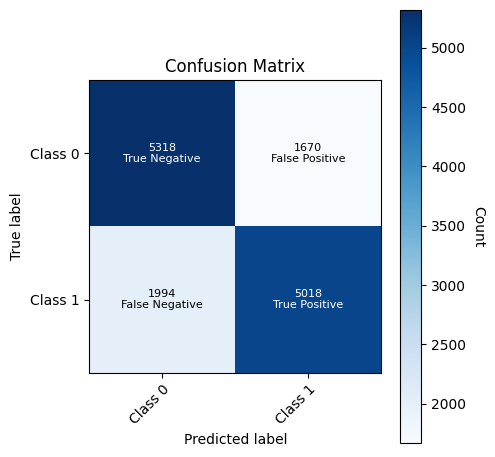

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_list)

cell_labels = np.array([
    ["True Negative", "False Positive"],
    ["False Negative", "True Positive"]
])


fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va="bottom")

classes = ['Class 0', 'Class 1']
ax.set(xticks=np.arange(len(classes)),
       yticks=np.arange(len(classes)),
       xticklabels=classes,
       yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion Matrix')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, f"{cm[i, j]}\n{cell_labels[i, j]}", ha="center", va="center", color=color, fontsize=8)

fig.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch

# 1. Example new clinical data (edit values as needed)
# Note: age is in days, gender is 1 (female) or 2 (male), as in your dataset
new_patient = {
    'age': 45 * 365,     # age in days (e.g., 45 years)
    'gender': 2,         # 1=female, 2=male
    'height': 170,       # cm
    'weight': 75,        # kg
    'ap_hi': 120,        # systolic BP
    'ap_lo': 80,         # diastolic BP
    'cholesterol': 1,    # 1, 2, or 3
    'gluc': 1,           # 1, 2, or 3
    'smoke': 0,          # 0 or 1
    'alco': 0,           # 0 or 1
    'active': 1          # 0 or 1
}

# 2. Prepare DataFrame in the correct column order (as in training)
feature_order = [
    'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
    'cholesterol', 'gluc', 'smoke', 'alco', 'active'
]
df_new = pd.DataFrame([new_patient])[feature_order]

# 3. Apply the same scaler as during training
# (Assumes 'scaler' is your fitted StandardScaler object)
X_new_scaled = scaler.transform(df_new)

# 4. Convert to torch tensor
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

# 5. Move to device and predict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_new_tensor = X_new_tensor.to(device)
model.to(device)
model.eval()
with torch.no_grad():
    output = model(X_new_tensor)
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).cpu().item()
    predicted_prob = probabilities[0, predicted_class].cpu().item()

# 6. Print results
print(f"Predicted class: {predicted_class} (0=No risk, 1=At risk)")
print(f"Predicted probability: {predicted_prob:.4f}")


Predicted class: 0 (0=No risk, 1=At risk)
Predicted probability: 0.7586
